### Mnist分类任务：

- 网络基本构建与训练方法，常用函数解析

- torch.nn.functional模块

- nn.Module模块


### 读取Mnist数据集
- 会自动进行下载

In [5]:
%matplotlib inline

In [6]:
from pathlib import Path
import requests

DATA_PATH = Path("data")
PATH = DATA_PATH / "mnist"

PATH.mkdir(parents=True, exist_ok=True)

URL = "http://deeplearning.net/data/mnist/"
FILENAME = "mnist.pkl.gz"

if not (PATH / FILENAME).exists():
        content = requests.get(URL + FILENAME).content
        (PATH / FILENAME).open("wb").write(content)

In [7]:
import pickle
import gzip

with gzip.open((PATH / FILENAME).as_posix(), "rb") as f:
        ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding="latin-1")

784是mnist数据集每个样本的像素点个数

(50000, 784)


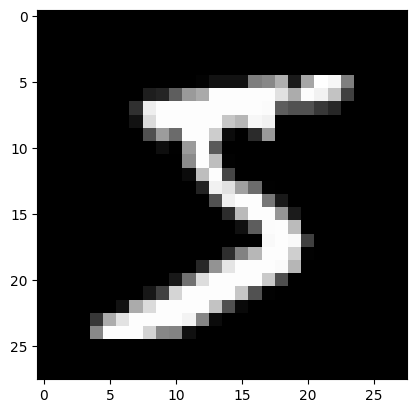

In [8]:
from matplotlib import pyplot
import numpy as np

pyplot.imshow(x_train[0].reshape((28, 28)), cmap="gray")
print(x_train.shape)

<img src="./img/4.png" alt="FAO" width="790">

<img src="./img/5.png" alt="FAO" width="790">

注意数据需转换成tensor才能参与后续建模训练


In [9]:
import torch

x_train, y_train, x_valid, y_valid = map(
    torch.tensor, (x_train, y_train, x_valid, y_valid)
)
n, c = x_train.shape
x_train, x_train.shape, y_train.min(), y_train.max()
print(x_train, y_train)
print(x_train.shape)
print(y_train.min(), y_train.max())

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]) tensor([5, 0, 4,  ..., 8, 4, 8])
torch.Size([50000, 784])
tensor(0) tensor(9)


### torch.nn.functional 很多层和函数在这里都会见到

torch.nn.functional中有很多功能，后续会常用的。那什么时候使用nn.Module，什么时候使用nn.functional呢？一般情况下，如果模型有可学习的参数，最好用nn.Module，其他情况nn.functional相对更简单一些

In [1]:
import torch.nn.functional as F

loss_func = F.cross_entropy

def model(xb):
    # 矩阵乘法操作
    return xb.mm(weights) + bias

In [11]:
bs = 64
xb = x_train[0:bs]  # a mini-batch from x
yb = y_train[0:bs]
weights = torch.randn([784, 10], dtype = torch.float,  requires_grad = True) 
bs = 64
bias = torch.zeros(10, requires_grad=True)

print(loss_func(model(xb), yb))

tensor(16.4980, grad_fn=<NllLossBackward0>)


### 创建一个model来更简化代码

- 必须继承nn.Module且在其构造函数中需调用nn.Module的构造函数
- 无需写反向传播函数，nn.Module能够利用autograd自动实现反向传播
- Module中的可学习参数可以通过named_parameters()或者parameters()返回迭代器

In [12]:
from torch import nn

class Mnist_NN(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden1 = nn.Linear(784, 128)
        self.hidden2 = nn.Linear(128, 256)
        self.out  = nn.Linear(256, 10)

    def forward(self, x):
        x = F.relu(self.hidden1(x))
        x = F.relu(self.hidden2(x))
        x = self.out(x)
        return x
        

In [13]:
net = Mnist_NN()
print(net)


Mnist_NN(
  (hidden1): Linear(in_features=784, out_features=128, bias=True)
  (hidden2): Linear(in_features=128, out_features=256, bias=True)
  (out): Linear(in_features=256, out_features=10, bias=True)
)


可以打印我们定义好名字里的权重和偏置项

In [14]:
for name, parameter in net.named_parameters():
    print(name, parameter,parameter.size())

hidden1.weight Parameter containing:
tensor([[-0.0065,  0.0278, -0.0168,  ...,  0.0197,  0.0035, -0.0200],
        [-0.0160,  0.0164, -0.0306,  ...,  0.0108, -0.0088, -0.0196],
        [ 0.0011,  0.0212,  0.0244,  ..., -0.0233, -0.0223, -0.0090],
        ...,
        [ 0.0304, -0.0266, -0.0290,  ...,  0.0288,  0.0044,  0.0127],
        [ 0.0210, -0.0273,  0.0006,  ..., -0.0082,  0.0181,  0.0023],
        [ 0.0164, -0.0036, -0.0233,  ...,  0.0019,  0.0084,  0.0236]],
       requires_grad=True) torch.Size([128, 784])
hidden1.bias Parameter containing:
tensor([-0.0301, -0.0145,  0.0294, -0.0288, -0.0084, -0.0143, -0.0268, -0.0267,
         0.0198, -0.0138, -0.0279, -0.0025, -0.0259,  0.0247,  0.0212,  0.0182,
        -0.0102,  0.0095, -0.0272,  0.0104,  0.0046, -0.0267,  0.0349, -0.0357,
         0.0264,  0.0309, -0.0286, -0.0108,  0.0082,  0.0356,  0.0125, -0.0115,
        -0.0157, -0.0221,  0.0286,  0.0020, -0.0275, -0.0152, -0.0118,  0.0335,
         0.0194, -0.0153,  0.0190, -0.0007, 

### 使用TensorDataset和DataLoader来简化

In [58]:
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

train_ds = TensorDataset(x_train, y_train)
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)

valid_ds = TensorDataset(x_valid, y_valid)
valid_dl = DataLoader(valid_ds, batch_size=bs * 2)

In [59]:
def get_data(train_ds, valid_ds, bs):
    return (
        DataLoader(train_ds, batch_size=bs, shuffle=True),
        DataLoader(valid_ds, batch_size=bs * 2),
    )

- 一般在训练模型时加上model.train()，这样会正常使用Batch Normalization和 Dropout
- 测试的时候一般选择model.eval()，这样就不会使用Batch Normalization和 Dropout

In [92]:
import numpy as np

def fit(steps, model, loss_func, opt, train_dl, valid_dl):
    for step in range(steps):
        model.train()
        for xb, yb in train_dl:
            loss_batch(model, loss_func, xb, yb, opt)

        model.eval()
        with torch.no_grad():
            losses, nums = zip(
                *[loss_batch(model, loss_func, xb, yb) for xb, yb in valid_dl]
            )
        val_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)
        print('当前step:'+str(step), '验证集损失：'+str(val_loss))

In [93]:
from torch import optim
def get_model():
    model = Mnist_NN()
    return model, optim.SGD(model.parameters(), lr=0.001)

In [94]:
def loss_batch(model, loss_func, xb, yb, opt=None):
    loss = loss_func(model(xb), yb)

    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()

    return loss.item(), len(xb)

### 三行搞定！

In [95]:
train_dl, valid_dl = get_data(train_ds, valid_ds, bs)
model, opt = get_model()
fit(25, model, loss_func, opt, train_dl, valid_dl)

当前step:0 验证集损失：2.2796445930480957
当前step:1 验证集损失：2.2440698066711424
当前step:2 验证集损失：2.1889826164245605
当前step:3 验证集损失：2.0985311767578123
当前step:4 验证集损失：1.9517273582458496
当前step:5 验证集损失：1.7341805934906005
当前step:6 验证集损失：1.4719875366210937
当前step:7 验证集损失：1.2273896869659424
当前step:8 验证集损失：1.0362271406173706
当前step:9 验证集损失：0.8963696184158325
当前step:10 验证集损失：0.7927186088562012
当前step:11 验证集损失：0.7141492074012756
当前step:12 验证集损失：0.6529350900650024
当前step:13 验证集损失：0.60417300491333
当前step:14 验证集损失：0.5643046331882476
当前step:15 验证集损失：0.5317994566917419
当前step:16 验证集损失：0.5047958114624024
当前step:17 验证集损失：0.4813900615692139
当前step:18 验证集损失：0.4618900228500366
当前step:19 验证集损失：0.4443243554592133
当前step:20 验证集损失：0.4297310716629028
当前step:21 验证集损失：0.416976597738266
当前step:22 验证集损失：0.406348459148407
当前step:23 验证集损失：0.3963301926612854
当前step:24 验证集损失：0.38733808159828187
